# Домашняя работа 5. Бустинг

*Мягкий дедлайн: 17 декабря, 21:00*

*Жесткий дедлайн: 19 декабря, 21:00*


Максимальная оценка 5 баллов :)

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston # sorry(not sorry)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [251]:
from scipy.optimize import minimize

### Задание 1. Градиентный бустинг своими руками  (2 балла)

Вам нужно реализовать упрощенный вариант градиентного бутсинга для задачи регресси. 


**Напоминание, как это работает:**

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается так:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu \in [0, 1]$ — темп обучения (гиперпараметр), $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма в ходе решения оптимизационной задачи:

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$


Заметьте, что в формуле выше нет $\nu$. Этот гиперпараметр используется для сокращения длины шага, оптимального при составлении композиции $a_N$. Идея отклонения от оптимума должна быть вам уже знакома как способ борьбы с переобучением, когда мы специально форсим модель работать чуть хуже, чем могла бы, на текущем шаге, чтобы сохранить обобщающую способность и не подогнаться под тренировочную выборку (или под шум).

С потерей в 0.5 балла можете принять $\gamma_N = 1$ для каждого $N$. На полный балл необходимо реализовать нахождение оптимального $\gamma_N$ на каждом шаге.

В качестве функции потерь $L$ возьмите MSE.

В качестве базовой модели можете использовать `DecisionTreeRegressor` из `sklearn`.
Для решения оптимизационной задачки можно воспользоваться алгоритмами из любых библиотек, например, `scipy.optimize`, или найти оптимум перебором по сетке из некоторого разумного диапазона.

Можно дописывать свои функции, если необходимо.

In [329]:
class GradientBoosting:
    def __init__(
        self, 
        base_model_class: object = DecisionTreeRegressor,
        base_model_params: dict = {'max_depth': None}, 
        n_estimators: int = 10,
        learning_rate: float = 0.1
        random_samp
    ):
        """
        
        Args:
          base_model_class: Class of the base learner.

          base_model_params: Hyperparameters of the base learner.
          
          n_estimators: Number of boosting stages.
          
          learning_rate: Value used to shrink contribution of each base learner to the model. 
          
        """
        
        self.base_model_class = base_model_class
        self.base_model_params = base_model_params
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        
        # list for optimal gammas at each iteration
        self.gammas = []
        
        # list for base models
        self.models = []
        
        # list for error tracking
        self.errors = []
        
    
    def find_optimal_gamma(self, 
                           y: np.array, 
                           old_predictions: np.array,
                           new_predictions: np.array) -> float:
        """You may add arguments if it's necessary for your optimization algorithm.
        
        Args:
          y: Target variable.

          old_predictions: Prediction of the additive model at the previous stage.
          
          new_predictions: Prediction of the base learner at the current stage. 
          
        Returns:
          Optimal value for gamma.
          
        """
        optimal_gamma = minimize(lambda gamma: np.sum((y - old_predictions - gamma*new_predictions)**2), x0 = 1).x[0]
        self.gammas.append(optimal_gamma)
    
    
    def _fit_base_model(self, X: np.ndarray, y: np.array):
        """Train one base learner. 
        
        Args:
          X: Feature matrix
          
          y: Target variable.
          
          
        Returns:
          Fitted base learner.
          
        """
        base_model = DecisionTreeRegressor(max_depth=self.base_model_params['max_depth'])
        base_model.fit(X, y)
        self.models.append(base_model)
        return base_model
    
        
    def fit(self, X: np.ndarray, y: np.array):
        """Train boosting ("sum" of base learners). 
        
        Args:
          X: Feature matrix
          
          y: Target variable.
          
          
        Returns:
          Fitted boosting.
          
        """
        
        for i in range(self.n_estimators):
            if len(self.models) == 0:
                    self.models.append(np.zeros(X.shape[0]))
                    self.gammas.append(1)
            else:
                s = 2*(y-self.predict(X))/len(X)
                old_predictions = self.predict(X)
                model = self._fit_base_model(X, s)
                
                self.find_optimal_gamma(y, old_predictions, model.predict(X))
            if i % 10 == 0:
                self.errors.append(mean_squared_error(y, self.predict(X)))
        return self
       
        
    def predict(self, X: np.ndarray):
        """Make prediction of fitted boosting. 
        
        Args:
          X: Feature matrix


        Returns:
          Prediction of fitted boosting.
          
        """
        if len(self.models) > 0:
            y_predicted = np.zeros(X.shape[0])
            for i, base_model in enumerate(self.models[1:]):
                y_predicted += self.learning_rate*self.gammas[i]*base_model.predict(X)
            return y_predicted
            

Проверьте вашу реализацию на бостонском датасете. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor (не меняйте параметры сида).

In [320]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [321]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [348]:
gb = GradientBoosting(n_estimators=1000, learning_rate=0.01)

In [349]:
%%time

gb.fit(X_train, y_train)
mean_squared_error(y_test, gb.predict(X_test))

Wall time: 2min 39s


18.674632420420302

In [350]:
len(gb.models)

1000

In [351]:
y_test[0:5]

array([12. , 15.2, 21. , 24. , 19.4])

In [352]:
gb.predict(X_test)[0:5]

array([14.37260738, 17.30203117, 25.30148554, 32.26610486, 20.34026662])

In [353]:
gb.errors

[599.8341160949868,
 500.5169952777063,
 409.3763228262078,
 334.8317345420535,
 273.8611986297408,
 223.992974361621,
 183.20540777116085,
 149.8449740190408,
 122.5592437871818,
 100.24205579428477,
 81.98867289622926,
 67.05910436066948,
 54.848106658211904,
 44.8606470217704,
 36.69183447925716,
 30.010505948446752,
 24.545801016632602,
 20.076180916798,
 16.420447642153803,
 13.430397986625307,
 10.984815707992365,
 8.984556988274386,
 7.34853150557188,
 6.010414887017167,
 4.915960045377064,
 4.020797826674219,
 3.288638437555918,
 2.6898002105587784,
 2.200006257300249,
 1.799400375018344,
 1.4717420529468517,
 1.2037480351797327,
 0.9845538680372872,
 0.8052734387218174,
 0.6586387312837678,
 0.5387051853993894,
 0.4406107092680395,
 0.3603785569633177,
 0.2947561227241548,
 0.2410830776721524,
 0.19718352965187028,
 0.1612777736795075,
 0.13191021276102652,
 0.10789027789596439,
 0.08824420995128156,
 0.07217555277801015,
 0.05903289716392513,
 0.048283416442512696,
 0.0394913

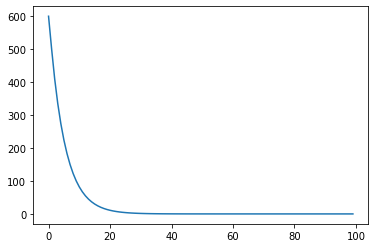

In [354]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(np.arange(len(gb.errors)), gb.errors)

In [355]:
len(gb.models)

1000

In [356]:
gb.gammas

[1,
 189.49999999255022,
 189.49999999254942,
 189.49999999254692,
 189.49999999255013,
 189.49999999254968,
 189.49999999254996,
 189.49999999254925,
 189.4999999925495,
 189.4999999925517,
 189.49999999255004,
 189.49999999255039,
 189.49999999254823,
 189.4999999925507,
 189.49999999254933,
 189.49999999255334,
 189.49999999254953,
 189.4999999925491,
 189.49999999255098,
 189.49999999254987,
 189.49999999254965,
 189.49999999254996,
 189.49999999254936,
 189.4999999925489,
 189.49999999254845,
 189.4999996621133,
 189.49999999254985,
 189.49999999254948,
 189.49999999254973,
 189.4999999925498,
 189.49999999254928,
 189.50000091924585,
 189.4999999925495,
 189.49999953686216,
 189.49999999254905,
 189.49999999254874,
 189.4999989082352,
 189.49999999255746,
 189.49999999254732,
 189.49999999254865,
 189.49999999255058,
 189.49999999254905,
 189.4999999925486,
 189.49999936799858,
 189.49999999254877,
 189.4999999925502,
 189.49999999254916,
 189.4999999925485,
 189.49999802557568,


In [389]:
from sklearn.ensemble import GradientBoostingRegressor

sk_gb = GradientBoostingRegressor(n_estimators=100)

sk_gb.fit(X_train, y_train)
mean_squared_error(y_test, sk_gb.predict(X_test))

11.439474022732165

In [395]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(GradientBoostingRegressor(), {
    "n_estimators" : np.arange(100, 1000, 250),
    "learning_rate" : [0.1, 0.05, 0.01, 0.001]
}, scoring="neg_mean_squared_error")
clf.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.1, 0.05, 0.01, 0.001],
                         'n_estimators': array([100, 350, 600, 850])},
             scoring='neg_mean_squared_error')

In [396]:
mean_squared_error(y_test, clf.best_estimator_.predict(X_test))

11.817873640446667

In [397]:
clf.best_score_

-8.4305018935117

In [398]:
clf.best_params_

{'learning_rate': 0.1, 'n_estimators': 100}

### Задание 2. Сравнение подходов (1.5 балла)

Скачайте данные о выдаче кредитов. Это данные с kaggle, целевая переменная `y` показывает, вернуло ли кредит физическое лицо.

In [403]:
!wget  -O 'bank_data.csv' -q 'https://www.dropbox.com/s/uy27mctxo0gbuof/bank_data.csv?dl=0'

In [404]:
df = pd.read_csv('bank_data.csv')
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
6043,57,admin.,single,university.degree,no,no,yes,cellular,may,mon,...,3,999,0,nonexistent,-1.8,92.893,-46.2,1.354,5099.1,1
6251,30,services,single,high.school,unknown,yes,no,telephone,apr,fri,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,-1
8125,49,blue-collar,divorced,unknown,unknown,no,no,cellular,jul,wed,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,-1
8714,29,admin.,single,university.degree,no,no,yes,cellular,aug,mon,...,2,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,-1
6647,64,housemaid,married,unknown,no,yes,no,telephone,may,wed,...,3,999,0,nonexistent,-1.8,93.876,-40.0,0.697,5008.7,1


Решите задачу предсказания возвращения кредита методами, перечисленными ниже:

- Случайный лес
- Бэггинг на деревьях (поставьте для базовых деревьев min_samples_leaf=1)
- Бэггинг, у которого базовой моделью является бустинг с большим числом деревьев (> 100)
- Бэггинг на логистических регрессиях

Используйте логистическую регрессию, случайный лес, `GradientBoostingClassifier` и `BaggingClassifier` из `sklearn`.

1) Какая из моделей имеет лучшее качество? С чем это связано?

2) Какая из моделей сильнее всего переобучается?


### Задание 3. Современные бустинги (1.5 балла)

Сравните на этих данных любую из трёх популярных имплементаций градиентного бустинга (xgboost, lightgbm, catboost). Подберите основные гиперпараметры (число деревьев, длина шага, глубина дерева/число листьев). Получилось ли круче, чем с моделями выше?

### Бонус (0.1 балла)

Прикрепите сюда что-нибудь для новогоднего настроения 👒

In [ ]:
# сюда